# Denoising autoencoder with regularization

The autoencoder will use some CNN layers. It will have a regularizer zeroing some nodes on CODE layer

In [1]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Input
from keras.datasets import mnist
import keras
import numpy as np
import matplotlib.pyplot as plt

from keras import regularizers

2024-07-06 00:46:27.160830: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-06 00:46:27.169050: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-06 00:46:27.180728: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-06 00:46:27.180747: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-06 00:46:27.188026: I tensorflow/core/platform/cpu_feature_gua

In [2]:
# Loading MNIST.

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
(x_train_copy, y_train_copy), (x_test_copy, y_test_copy) = keras.datasets.mnist.load_data()

# Scaling the values to be floats between 0 and 1.
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Creating a copy so that inserting the watermark doesnt affect the training dataset.
x_train_copy = x_train_copy.astype('float32') / 255.
x_test_copy = x_test_copy.astype('float32') / 255.
x_train_copy = np.reshape(x_train_copy, (len(x_train_copy), 28, 28, 1))
x_test_copy = np.reshape(x_test_copy, (len(x_test_copy), 28, 28, 1))

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [3]:
# Water mark design "X" in this case.
x_water_mark = np.array([
    [1, 0, 0, 0, 1],
    [0, 1, 0, 1, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 0, 1, 0],
    [1, 0, 0, 0, 1]
])

In [4]:
# Water mark adder, at a random position in the image.
def add_random_watermark(image, watermark):
    h, w = image.shape[0:2]
    wm_h, wm_w = watermark.shape

    top = np.random.randint(0, h - wm_h + 1)
    left = np.random.randint(0, w - wm_w + 1)

    image[top:top+wm_h, left:left+wm_w, 0] = np.maximum(image[top:top+wm_h, left:left+wm_w, 0], watermark)

    return image

In [5]:
# Add n water marks.
number_of_watermarks = 10
for i in range(0, number_of_watermarks):
    x_train_noisy = np.array([add_random_watermark(image, x_water_mark) for image in x_train_copy])
    x_test_noisy = np.array([add_random_watermark(image, x_water_mark) for image in x_test_copy])

# Cliping the cel values.
x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

print(x_train_noisy.shape)
print(x_test_noisy.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


# Visulazing the watermarked data

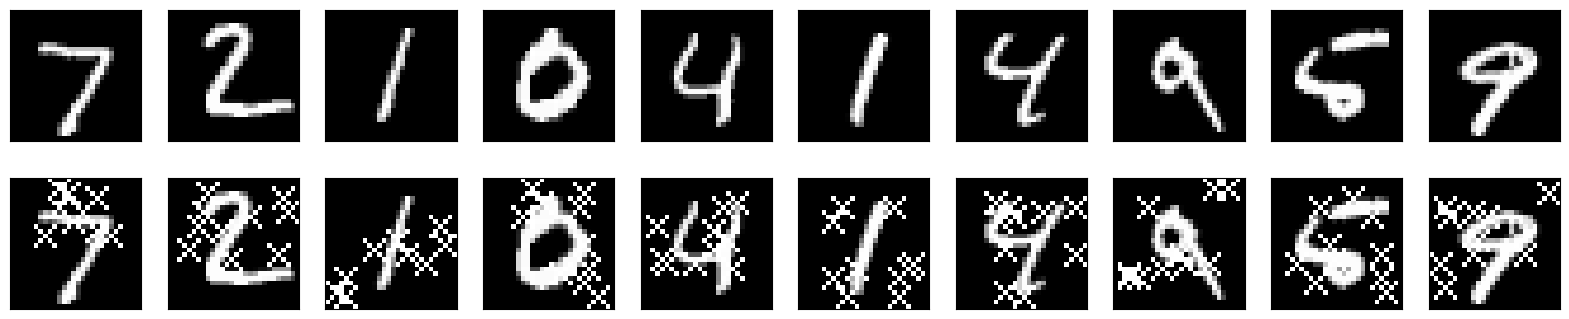

In [6]:
n_samples_displayed = 10
plt.figure(figsize=(20, 4))

for i in range(n_samples_displayed):
    # Original dataset
    ax = plt.subplot(2, n_samples_displayed, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Marked dataset
    ax = plt.subplot(2, n_samples_displayed, i + 1 + n_samples_displayed)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Creating the smaller model

In [7]:
'''
input = Input(shape=(28,28,1), name='Input')
conv = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', name='conv_1')
x = conv(input)
maxp = MaxPooling2D(pool_size=(2,2), padding='same')
x = maxp(x)

x = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu',name='conv_2')(x)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)

x = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu',
                  name='conv_3', activity_regularizer=regularizers.l1(10e-5))(x)
x = MaxPooling2D(pool_size=(2,2), padding='same')(x)

# Associated with decoder
x = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu',
                  name='conv_4')(x)
x = UpSampling2D(size=(2,2))(x)

# Rest of the layers
x = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu',name='conv_5')(x)
x = UpSampling2D(size=(2,2))(x)

x = Conv2D(filters=8, kernel_size=(3,3), activation='relu',name='conv_6')(x)
x = UpSampling2D(size=(2,2))(x)

output = Conv2D(filters=1, kernel_size=(3,3), padding='same', activation='sigmoid', name='output')(x)

autoencoder = Model(inputs= input, outputs=output, name='CAE')
autoencoder.summary()
'''

"\ninput = Input(shape=(28,28,1), name='Input')\nconv = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', name='conv_1')\nx = conv(input)\nmaxp = MaxPooling2D(pool_size=(2,2), padding='same')\nx = maxp(x)\n\nx = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu',name='conv_2')(x)\nx = MaxPooling2D(pool_size=(2,2), padding='same')(x)\n\nx = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu',\n                  name='conv_3', activity_regularizer=regularizers.l1(10e-5))(x)\nx = MaxPooling2D(pool_size=(2,2), padding='same')(x)\n\n# Associated with decoder\nx = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu',\n                  name='conv_4')(x)\nx = UpSampling2D(size=(2,2))(x)\n\n# Rest of the layers\nx = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu',name='conv_5')(x)\nx = UpSampling2D(size=(2,2))(x)\n\nx = Conv2D(filters=8, kernel_size=(3,3), activation='relu',name='conv_6')(x)\

# Creating the big model

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Dropout, Add, PReLU
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [9]:
# Encoder
input_img = Input(shape=(28, 28, 1), name='Input')

# Layer 1
x = Conv2D(64, (3, 3), padding='same', name='conv_1')(input_img)
x = PReLU()(x)
x = BatchNormalization()(x)
residual_1 = x
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.3)(x)

# Layer 2
x = Conv2D(128, (3, 3), padding='same', name='conv_2')(x)
x = PReLU()(x)
x = BatchNormalization()(x)
residual_2 = x
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.3)(x)

# Layer 3
x = Conv2D(256, (3, 3), padding='same', name='conv_3')(x)
x = PReLU()(x)
x = BatchNormalization()(x)
residual_3 = x
x = MaxPooling2D((2, 2), padding='valid')(x)
x = Dropout(0.3)(x)

# Latent space
encoded = Conv2D(512, (3, 3), padding='same', name='conv_4', activity_regularizer=regularizers.l2(10e-5))(x)
encoded = PReLU()(encoded)
encoded = BatchNormalization()(encoded)

# Decoder
# Layer 1
x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='valid', name='deconv_1')(encoded)
x = PReLU()(x)
x = BatchNormalization()(x)
x = Add()([x, residual_3])  # Residual connection

# Layer 2
x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', name='deconv_2')(x)
x = PReLU()(x)
x = BatchNormalization()(x)
x = Add()([x, residual_2])  # Residual connection

# Layer 3
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', name='deconv_3')(x)
x = PReLU()(x)
x = BatchNormalization()(x)
x = Add()([x, residual_1])  # Residual connection

# Output layer
output = Conv2D(1, (3, 3), padding='same', activation='sigmoid', name='output')(x)

# Model
autoencoder = Model(inputs=input_img, outputs=output, name='Advanced_CAE')
autoencoder.summary()

2024-07-06 00:46:32.131206: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-07-06 00:46:32.131222: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: vitor-DellG15
2024-07-06 00:46:32.131225: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: vitor-DellG15
2024-07-06 00:46:32.131282: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 535.183.1
2024-07-06 00:46:32.131290: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 535.183.1
2024-07-06 00:46:32.131292: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 535.183.1


Model: "Advanced_CAE"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 28, 28, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_1 (Conv2D)     │ (None, 28, 28,    │        640 │ Input[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu (PReLU)     │ (None, 28, 28,    │     50,176 │ conv_1[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        256 │ p_re_lu[0][0]     │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 14, 14,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv2D)     │ (None, 14, 14,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_1 (PReLU)   │ (None, 14, 14,    │     25,088 │ conv_2[0][0]      │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ p_re_lu_1[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 7, 7, 128) │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv2D)     │ (None, 7, 7, 256) │    295,168 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_2 (PReLU)   │ (None, 7, 7, 256) │     12,544 │ conv_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 256) │      1,024 │ p_re_lu_2[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 3, 3, 256) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 3, 3, 256) │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4 (Conv2D)     │ (None, 3, 3, 512) │  1,180,160 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_3 (PReLU)   │ (None, 3, 3, 512) │      4,608 │ conv_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 3, 3, 512) │      2,048 │ p_re_lu_3[0][0]   │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 3,284,993 (12.53 MB)

 Trainable params: 3,282,177 (12.52 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [10]:
# Compiling
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [11]:
# Treinando o modelo
autoencoder.fit(x_train_noisy, x_train, epochs=15, batch_size=256)

Epoch 1/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 109s 455ms/step - loss: 24.2217
Epoch 2/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 93s 396ms/step - loss: 0.1830
Epoch 3/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 95s 404ms/step - loss: 0.1149
Epoch 4/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 95s 404ms/step - loss: 0.0963
Epoch 5/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 95s 405ms/step - loss: 0.0869
Epoch 6/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 95s 404ms/step - loss: 0.0817
Epoch 7/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 95s 405ms/step - loss: 0.0783
Epoch 8/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 95s 403ms/step - loss: 0.0756
Epoch 9/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 95s 404ms/step - loss: 0.0740
Epoch 10/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 104s 443ms/step - loss: 0.0724
Epoch 11/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 94s 399ms/step - loss: 0.0714
Epoch 12/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 94s 400ms/step - loss: 0.0706
Epoch 13/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 95s 405ms/step - loss: 0.0699
Epoch 14/15
235/235 ━━━━━━━━━━━━━━━━━━━━ 93s 395ms/step - loss: 0.0692
Epoch 15/15


In [12]:
decoded_imgs = autoencoder.predict(x_test_noisy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


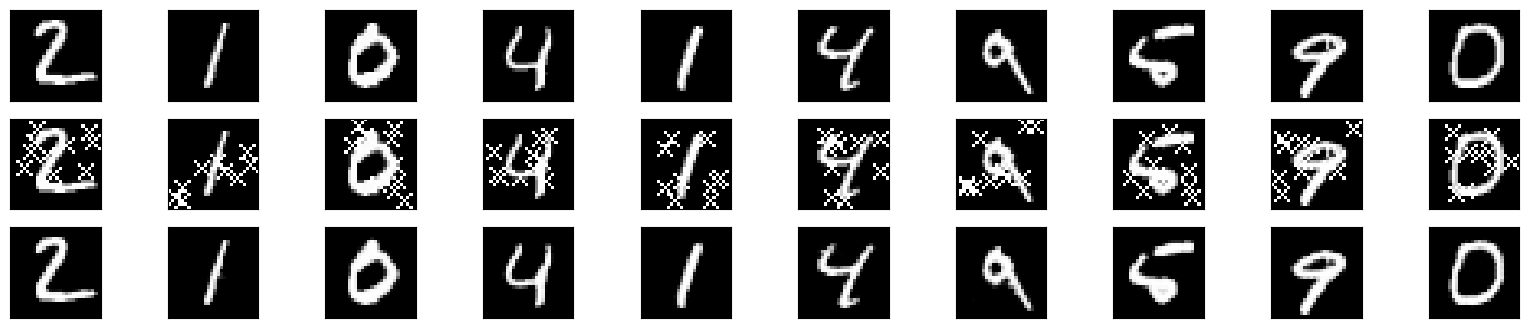

In [13]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(28, 28))  # imagens originais, sem ruído
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy test images
    ax = plt.subplot(3, n, i + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, n, i + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()